In [1]:
from torch import load as torch_load
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from datasets import load_dataset
from fasttext import load_model as fasttext_load_model

from lstm_utils.model import BiLSTM, LSTM
from lstm_utils.train import train, test
from lstm_utils.utils import vectorize_text

/home/cybertech/tomekg/NLP_learning/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = load_dataset('emotion')
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [3]:
ds.set_format('pandas')

In [4]:
ft_model_polish = fasttext_load_model('fasttext_utils/cc.pl.300.bin')

In [5]:
train_ds = vectorize_text(X=ds['train']['text'], y=ds['train']['label'], ft_model=ft_model_polish, max_num_of_words=30)
val_ds = vectorize_text(X=ds['validation']['text'], y=ds['validation']['label'], ft_model=ft_model_polish, max_num_of_words=30)
test_ds = vectorize_text(X=ds['test']['text'], y=ds['test']['label'], ft_model=ft_model_polish, max_num_of_words=30)

In [6]:
train_ds[10][0], train_ds[10][0].shape, train_ds[10][1]

(tensor([[ 0.0566,  0.0867,  0.0002,  ..., -0.0142,  0.0050,  0.0935],
         [ 0.0357, -0.0066, -0.0040,  ..., -0.1219,  0.0627, -0.0068],
         [-0.0180, -0.0750,  0.0529,  ..., -0.0240,  0.0017,  0.0608],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]),
 torch.Size([30, 300]),
 0)

In [7]:
BATCH_SIZE = 16

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)

In [8]:
EMBEDDING_DIM = 300
OUTPUT_DIM = 6

 57%|█████▋    | 574/1000 [21:23<15:52,  2.24s/it, Epoch=574, train loss=0.000283, train f1=0.996, valid loss=0.302, valid f1=0.782]

Early stopping on epoch 574


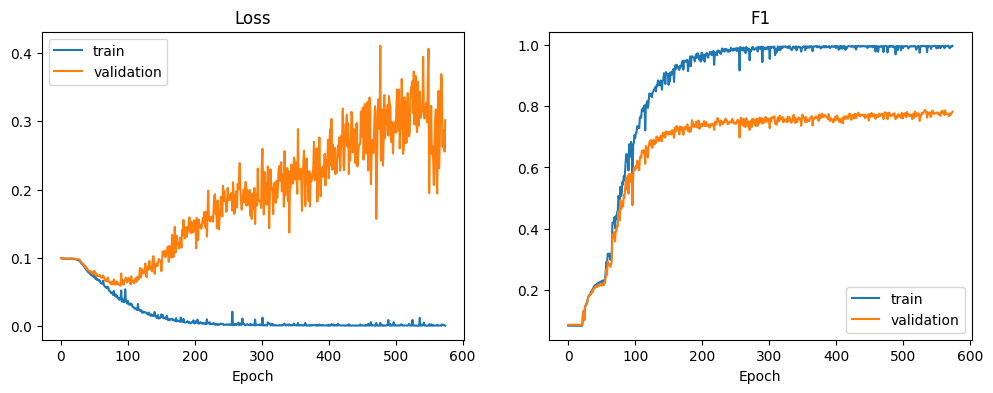

LSTM(
  (_lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.2)
  (_clf): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=16, out_features=6, bias=True)
  )
)

In [9]:
HIDDEN_DIM = 256
NUM_LAYERS_LSTM = 2
DROPOUT_LSTM = 0.2
DROPOUT_CLF = 0.2
LEARNING_RATE = 0.0001
NUM_EPOCHS = 1000
PATIENCE = 40

lstm = LSTM(
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    num_layers_lstm=NUM_LAYERS_LSTM,
    dropout_lstm=DROPOUT_LSTM,
    dropout_clf=DROPOUT_CLF
).to('cuda')
optimizer = Adam(lstm.parameters(), lr=LEARNING_RATE)

train(
    model=lstm,
    optimizer=optimizer,
    loss_fn=CrossEntropyLoss(),
    epochs=NUM_EPOCHS,
    train_dl=train_dl,
    val_dl=val_dl,
    patience=PATIENCE,
    print_metrics=True,
    device='cuda',
    best_model_path='lstm_utils/best_lstm.pth'
)

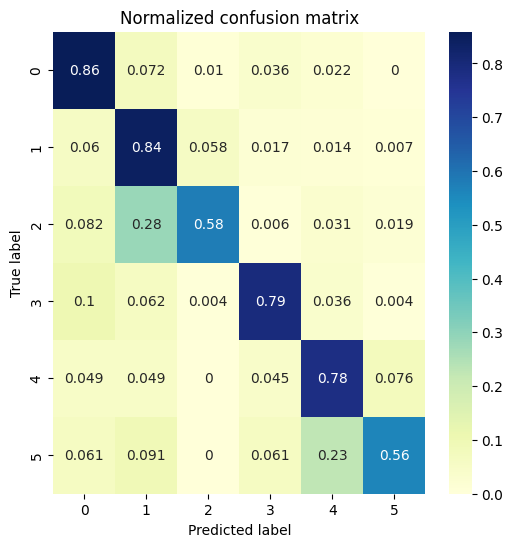

{'precision': 0.7501608388130859,
 'recall': 0.735871530116536,
 'f1-score': 0.7424152695500847,
 'support': 2000.0}

In [10]:
lstm.load_state_dict(torch_load('lstm_utils/best_lstm.pth'))
lstm.eval()
test(
    model=lstm,
    dataloader=test_dl,
    device='cuda'
)['macro avg']

  0%|          | 0/1000 [00:00<?, ?it/s]

 23%|██▎       | 231/1000 [12:30<41:37,  3.25s/it, Epoch=231, train loss=0.00065, train f1=0.993, valid loss=0.176, valid f1=0.726] 

Early stopping on epoch 231


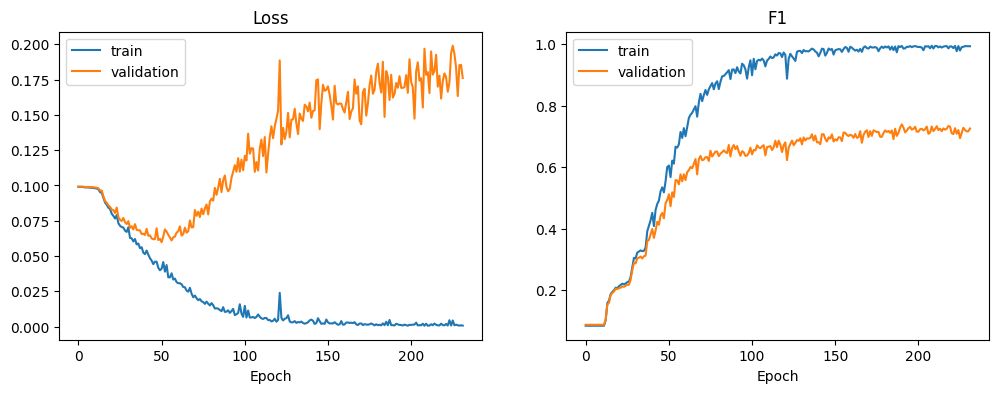

BiLSTM(
  (_lstm): LSTM(300, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (_clf): Sequential(
    (0): Linear(in_features=512, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
    (7): ReLU(inplace=True)
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=16, out_features=6, bias=True)
  )
)

In [13]:
HIDDEN_DIM = 256
NUM_LAYERS_LSTM = 2
DROPOUT_LSTM = 0.2
DROPOUT_CLF = 0.2
LEARNING_RATE = 0.0001
NUM_EPOCHS = 1000
PATIENCE = 40

bilstm = BiLSTM(
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    num_layers_lstm=NUM_LAYERS_LSTM,
    dropout_lstm=DROPOUT_LSTM,
    dropout_clf=DROPOUT_CLF
).to('cuda')
optimizer = Adam(bilstm.parameters(), lr=LEARNING_RATE)

train(
    model=bilstm,
    optimizer=optimizer,
    loss_fn=CrossEntropyLoss(),
    epochs=NUM_EPOCHS,
    train_dl=train_dl,
    val_dl=val_dl,
    patience=PATIENCE,
    print_metrics=True,
    device='cuda',
    best_model_path='lstm_utils/best_bilstm.pth'
)

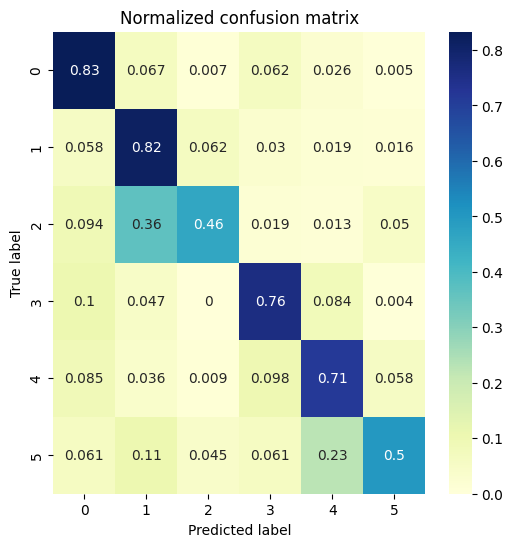

{'precision': 0.6851341540461808,
 'recall': 0.6803798368118742,
 'f1-score': 0.6813003037675521,
 'support': 2000.0}

In [15]:
bilstm.load_state_dict(torch_load('lstm_utils/best_bilstm.pth'))
bilstm.eval()
test(
    model=bilstm,
    dataloader=test_dl,
    device='cuda'
)['macro avg']